# UAS PE

---
5 = Mendeteksi jenis kelamin

6 = mendeteksi umur

10 =  jarak orang dari kamera

In [1]:
# Import library
import cv2 as cv
import math
import time
import cv2
from google.colab.patches import cv2_imshow
import imutils
!git clone https://github.com/misbah4064/age_and_gender_detection.git
%cd age_and_gender_detection

Cloning into 'age_and_gender_detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (11/11), done.
/content/age_and_gender_detection


In [ ]:
# Download data kaggle
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/age_and_gender_detection/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 211MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [ ]:
# jarak kamera dari wajah satuan cm
Known_distance = 30
 
# lebar wajah nyata satuan cm
Known_width = 14.3
 
# objek pendeteksi wajah
face_detec = cv2.CascadeClassifier("content/drive/MyDrive/Colab Notebooks/haarcascade_frontalface_default.xml")

#program ambil data wajah
def face_data(image):
 
    face_width = 0 
 
    # mengkonversi warna menjadi gambar berwarna abu abu
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    # mendeteksi wajah dalam variabel gambar
    faces = face_detec.detectMultiScale(gray_image, 1.3, 5)
 
    # perulangan melalui deteksi wajah dalam gambar
    # mendapatkan titik x, y , lebar dan tinggi
    for (x, y, h, w) in faces:
 
        # menggambar persegi panjang di wajah
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 255), 2)
 
        # mendapatkan lebar wajah per piksel
        face_width = w
 
    return face_width

# rumus focal length pencari panjang fokus
def Focal_Length_Find(know_real_distance, know_real_width, width_in_pixel_image):
 
    
    focal_length = (know_real_width * know_real_distance) / width_in_pixel_image
    return focal_length
 
#rumus jarak
def Distance_find(Focal_Length, real_face_width, face_width_in_frame):
 
    distance = (face_width_in_frame * Focal_Length)/real_face_width
    return distance


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


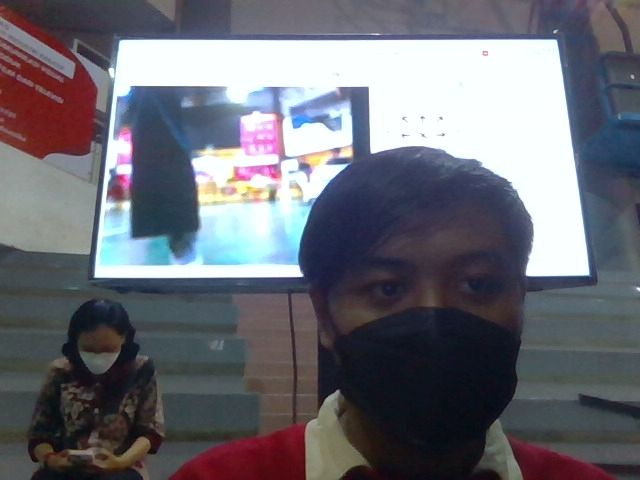

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# membaca reference_image dari direktori
ref_image = cv2.imread(filename)

# temukan lebar wajah (piksel) di reference_image
image_facepx_width = face_data(ref_image)

print(image_facepx_width)

#mencari titik fokus dengan rumus focal length finder
Focal_length_found = Focal_Length_Find(Known_distance, Known_width, image_facepx_width) 
 
print(Focal_length_found)

Distance = Distance_find(Focal_length_found, Known_width, image_facepx_width)
cv2.putText( ref_image, f"Jarak: {round(Distance,2)} CM", (30, 35), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)


def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-7)', '(8-14)', '(15-24)', '(25-37)', '(38-47)', '(48-59)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace
 

# menampilkan gambar
ref_image = age_gender_detector(ref_image)
cv2_imshow( ref_image)
cv2.waitKey(0)

error: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
